In [2]:
# standard libs
import os
os.environ["PROJ_LIB"] = r"C:\Users\12035\anaconda3\Library\share\basemap";
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json

# plotting libs
import seaborn as sns

# geospatial libs
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon
import geopandas as gpd
import folium
import plotly.graph_objects as go
import plotly_express as px

# set in line plotly 
from plotly.offline import init_notebook_mode;
init_notebook_mode(connected=True)

print(os.getcwd())


C:\Users\12035


In [7]:
# import corporate response data
cc_df = pd.read_csv('C:\\Users\\12035\\OneDrive\\Documents\\Corporations Responses\\Climate Change\\2019_Full_Climate_Change_Dataset.csv')
ws_df = pd.read_csv('C:\\Users\\12035\\OneDrive\\Documents\\Corporations Responses\\Water Security\\2019_Full_Water_Security_Dataset.csv')

C:\Users\12035\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning:

Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.



In [3]:

cities_df = pd.read_csv("C:\\Users\\12035\\OneDrive\\Documents\\Cities Responses\\2020_Full_Cities_Dataset.csv")

In [9]:
# external data - import CDC social vulnerability index data - census tract level
svi_df = pd.read_csv("C:\\Users\\12035\\Downloads\\SVI2018_US.csv")

In [10]:
# cities metadata - lat,lon locations for US cities
cities_meta_df = pd.read_csv("C:\\Users\\12035\\OneDrive\\Documents\\Simple Maps US Cities Data\\uscities.csv")

# cities metadata - CDP metadata on organisation HQ cities
cities_cdpmeta_df = pd.read_csv("C:\\Users\\12035\\OneDrive\\Documents\\Locations of Corporations\\NA_HQ_public_data.csv")

In [11]:

   def list_dedupe(x):
    """
    Convert list to dict and back to list to dedupe
    
    Parameters
    ----------
    x: list
        Python list object
        
    Returns
    -------
    dictionary:
        dictionary object with duplicates removed
        
    """
    return list(dict.fromkeys(x))

In [13]:
cities_6_2 = cities_df[cities_df['Question Number'] == '6.2']\
        .rename(columns={'Organization': 'City'})

cities_6_2['Response Answer'] = cities_6_2['Response Answer'].fillna('No Response')

cities_6_2.head()

,Questionnaire,Year Reported to CDP,Account Number,City,Country,CDP Region,Parent Section,Section,Question Number,Question Name,Column Number,Column Name,Row Number,Row Name,Response Answer,Comments,File Name,Last update
2093,Cities 2020,2020,54538,Bath and North East Somerset,United Kingdom of Great Britain and Northern I...,Europe,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,9/7/2020 9:45
2107,Cities 2020,2020,42120,City of Salvador,Brazil,Latin America,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,9/7/2020 9:45
2112,Cities 2020,2020,826210,Junta Intermunicipal de Medio Ambiente de la C...,Mexico,Latin America,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,9/7/2020 9:45
2594,Cities 2020,2020,37241,City of Berkeley,United States of America,North America,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,9/7/2020 9:45
3561,Cities 2020,2020,50549,City of Fort Worth,United States of America,North America,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,9/7/2020 9:45


In [16]:
# state abbreviation dictionary
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# map dict to clean full state names to abbreviations
cities_cdpmeta_df['state'] = cities_cdpmeta_df['address_state'].map(us_state_abbrev)

# infill non-matched from dict
cities_cdpmeta_df['state'] = cities_cdpmeta_df['state'].fillna(cities_cdpmeta_df['address_state'])
cities_cdpmeta_df['state'] = cities_cdpmeta_df['state'].replace({'ALBERTA':'AB'})
cities_cdpmeta_df['address_city'] = cities_cdpmeta_df['address_city'].replace({'CALGARY':'Calgary'})
cities_cdpmeta_df= cities_cdpmeta_df.drop(columns=['address_state'])

# create joint city state variable
cities_cdpmeta_df['city_state'] = cities_cdpmeta_df['address_city'].str.cat(cities_cdpmeta_df['state'],sep=", ")

cities_cdpmeta_df

,account_number,organization,public,invitation_status,request_status,theme,survey_year,survey_name,hq_country,address_city,address_lat,adress_long,state,city_state
0,58859,Hewlett Packard Enterprise Company,public,Submitted,Submitted,Climate Change,2020,Climate Change 2020,United States of America,San Jose,NaN,NaN,CA,"San Jose, CA"
1,31831,Bausch Health Cos. Inc.,public,Submitted,Submitted,Climate Change,2020,Climate Change 2020,Canada,Rochester,NaN,NaN,NY,"Rochester, NY"
2,40952,BWI Group,public,Submitted,Submitted,Climate Change,2020,Climate Change 2020,China,NaN,NaN,NaN,NaN,NaN
3,30634,Guangdong Textiles,public,Submitted,Submitted,Climate Change,2020,Climate Change 2020,China,NaN,NaN,NaN,NaN,NaN
4,19582,Johnson Controls International PLC,public,Submitted,Submitted,Climate Change,2020,Climate Change 2020,Ireland,Cork,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,38267,"American Cleaning Supply, Inc.",public,Submitted,Submitted,Water,2020,Water Security 2020,United States of America,NaN,NaN,NaN,NaN,NaN
3295,848018,CANACOL ENERGY LTD.,public,Submitted,Submitted,Water,2020,Water Security 2020,Canada,Calgary,NaN,NaN,AB,"Calgary, AB"
3296,61423,AlmadenÂ Press,public,Submitted,Submitted,Water,2020,Water Security 2020,United States of America,NaN,NaN,NaN,NaN,NaN
3297,847168,Raytheon Technologies Corporation,public,Submitted,Submitted,Water,2020,Water Security 2020,United States of America,Waltham,NaN,NaN,MA,"Waltham, MA"


In [17]:
cities_count = cities_cdpmeta_df[['organization', 'address_city', 'state', 'city_state']]\
        .groupby(['address_city', 'state', 'city_state']).count().\
            sort_values(by = ['organization'],ascending = False)\
                .reset_index()\
                    .rename(columns={'organization' : 'num_orgs'})
cities_count.head()

,address_city,state,city_state,num_orgs
0,New York,NY,"New York, NY",138
1,Calgary,AB,"Calgary, AB",94
2,Toronto,ON,"Toronto, ON",85
3,San Jose,CA,"San Jose, CA",54
4,Chicago,IL,"Chicago, IL",45


In [18]:
# convert indexes to columns'
cities_count.reset_index(inplace=True)
cities_count = cities_count.rename(columns = {'index':'city_id'})
cities_df.reset_index(inplace=True)
cities_df = cities_df.rename(columns = {'index':'city_org_id'})

In [21]:
# convert id and city label columns into lists
city_id_no = list_dedupe(cities_count['city_id'].tolist())
city_name = list_dedupe(cities_count['address_city'].tolist())

city_org_id_no = list_dedupe(cities_df['city_org_id'].tolist())
city_org_name = list_dedupe(cities_df['Organization'].tolist())

In [25]:
# remove added index column in cities df
cities_df.drop('city_org_id', inplace=True, axis=1)
cities_count.drop('city_id', inplace=True, axis=1)

# zip to join the lists and dict function to convert into dicts
city_dict = dict(zip(city_id_no, city_name))
city_org_dict = dict(zip(city_org_id_no, city_org_name))

In [29]:
# compare dicts - matching when city name appears as a substring in the full city org name
city_names_df = pd.DataFrame(columns=['City ID No.','address_city', 'City Org ID No.','City Org', 'Match']) # initiate empty df

for ID, seq1 in city_dict.items():
    for ID2, seq2 in city_org_dict.items():
        m = re.search(seq1, seq2) # match string with regex search 
        if m:
            match = m.group()
            # Append rows in Empty Dataframe by adding dictionaries 
            city_names_df = city_names_df.append({'City ID No.': ID, 'address_city': seq1, 'City Org ID No.': ID2, 'City Org': seq2, 'Match' : match}, ignore_index=True)
            
# subset for city to city org name matches
city_names_df = city_names_df.loc[:,['address_city','City Org']]

city_names_df.head()

,address_city,City Org
0,New York,New York City
1,Calgary,City of Calgary
2,Toronto,City of Toronto
3,Chicago,City of Chicago
4,Houston,City of Houston


In [30]:
cities_count  = pd.merge(cities_count, city_names_df, on='address_city', how='left')
cities_count.head()

,address_city,state,city_state,num_orgs,City Org
0,New York,NY,"New York, NY",138,New York City
1,Calgary,AB,"Calgary, AB",94,City of Calgary
2,Toronto,ON,"Toronto, ON",85,City of Toronto
3,San Jose,CA,"San Jose, CA",54,NaN
4,Chicago,IL,"Chicago, IL",45,City of Chicago


In [31]:
cities_6_2 = cities_6_2[['City', 'Response Answer']].rename(columns={'City' : 'City Org'})
cities_count = pd.merge(left=cities_count, right=cities_6_2, how='left', 
                        on ='City Org').rename(columns={'Response Answer' : 'Sustainability Project Collab.'})

cities_count['Sustainability Project Collab.'] = cities_count['Sustainability Project Collab.'].fillna('No Response')

In [32]:
cities_count.head()

,address_city,state,city_state,num_orgs,City Org,Sustainability Project Collab.
0,New York,NY,"New York, NY",138,New York City,Yes
1,Calgary,AB,"Calgary, AB",94,City of Calgary,Yes
2,Toronto,ON,"Toronto, ON",85,City of Toronto,Yes
3,San Jose,CA,"San Jose, CA",54,NaN,No Response
4,Chicago,IL,"Chicago, IL",45,City of Chicago,Yes


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 <a list of 38 Text xticklabel objects>)

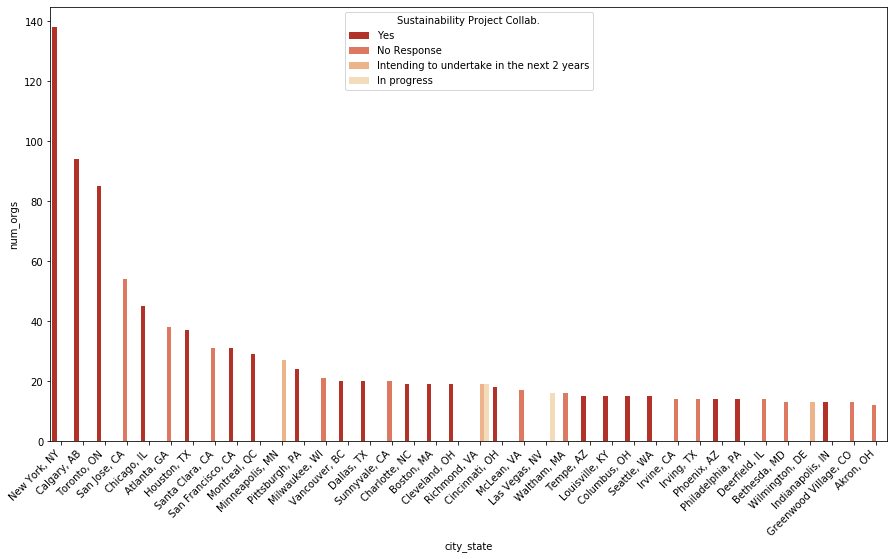

In [33]:
cities_count_50 = cities_count.iloc[0:40,:]

plt.figure(figsize=(15,8))
ax = sns.barplot(
    x="city_state", y="num_orgs",
    hue = "Sustainability Project Collab.",
    data=cities_count_50 ,
    palette="OrRd_r"
)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium'  
)


In [34]:
# subset for lat, lng cities data
cities_meta_df = cities_meta_df[['city', 'state_id', 'lat','lng']].rename(columns={'city' : 'address_city', 'state_id' : 'state'})
cities_meta_df.head()

,address_city,state,lat,lng
0,New York,NY,40.6943,-73.9249
1,Los Angeles,CA,34.1139,-118.4068
2,Chicago,IL,41.8373,-87.6862
3,Miami,FL,25.7839,-80.2102
4,Dallas,TX,32.7936,-96.7662


In [35]:
# join coordinates to cities count
cities_count = pd.merge(left=cities_count, right=cities_meta_df, how='left', on=['address_city', 'state'])

# convert text response to question 6.2 to an integar encoding 
resp_int_df = cities_count[["Sustainability Project Collab."]]
resp_int_df= resp_int_df.rename(columns={'Sustainability Project Collab.' : 'resp_int'})

labels = resp_int_df['resp_int'].unique().tolist()
mapping = dict( zip(labels,range(len(labels))) )
resp_int_df.replace({'resp_int': mapping},inplace=True)

resp_list = resp_int_df['resp_int'].tolist()
cities_count['resp_int'] = resp_list 
cities_count.head()

,address_city,state,city_state,num_orgs,City Org,Sustainability Project Collab.,lat,lng,resp_int
0,New York,NY,"New York, NY",138,New York City,Yes,40.6943,-73.9249,0
1,Calgary,AB,"Calgary, AB",94,City of Calgary,Yes,NaN,NaN,0
2,Toronto,ON,"Toronto, ON",85,City of Toronto,Yes,NaN,NaN,0
3,San Jose,CA,"San Jose, CA",54,NaN,No Response,37.3019,-121.8486,1
4,Chicago,IL,"Chicago, IL",45,City of Chicago,Yes,41.8373,-87.6862,0


In [36]:
# plot spatial bubble map
cities_count['text'] = cities_count['address_city'] + '<br>Number of Orgs: ' + (cities_count['num_orgs']).astype(str) +\
    '<br>Sustainability Project Colloboration: ' + (cities_count['Sustainability Project Collab.']).astype(str)
limits = [(0,20),(21,40),(41,60),(61,80),(81,100)]
cities = []
scale = 5

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = cities_count['lng'],
        lat = cities_count['lat'],
        text = cities_count['text'],
        marker = dict(
            size = cities_count['num_orgs']*scale,
            color = cities_count['resp_int'],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = '2019 CDP Climate Change Corporate Responders (Public) by City',
        showlegend = False,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

In [37]:
cc_2_4a = cc_df[cc_df['question_number'] == 'C2.4a']

In [38]:
cities_cdpmeta_join = cities_cdpmeta_df[["account_number", 'survey_year', 'address_city']]
cc_2_4a = pd.merge(left=cc_2_4a, right=cities_cdpmeta_join,  left_on=['account_number','survey_year'], right_on = ['account_number','survey_year'])

In [39]:
cc_nyc = cc_2_4a[(cc_2_4a['address_city'] =='New York')]

In [40]:
cities_6_2['City Org'] = cities_6_2['City Org'].replace({'New York City':'New York'})
cc_nyc = pd.merge(left=cc_nyc, right= cities_6_2,  left_on=['address_city'], right_on = ['City Org']).rename(columns={'Response Answer' : 'sustain_collab'})
cc_nyc.head()

,account_number,organization,survey_year,response_received_date,accounting_period_to,ors_response_id,submission_date,page_name,module_name,question_number,...,table_columns_unique_reference,row_number,row_name,data_point_name,data_point_id,response_value,comments,address_city,City Org,sustain_collab
0,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,C2.4a_c5-Type of financial impact,3,NaN,C2.4a_C5_Provide details of opportunities iden...,7562.0,"Other, please specify: Energy efficiency and r...",NaN,New York,New York,Yes
1,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,C2.4a_c5-Type of financial impact,3,NaN,C2.4a_C5_Provide details of opportunities iden...,7562.0,"Other, please specify: Energy efficiency and r...",NaN,New York,New York,Yes
2,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,C2.4a_c7-Time horizon,2,NaN,C2.4a_C7_Provide details of opportunities iden...,7564.0,Current,NaN,New York,New York,Yes
3,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,C2.4a_c7-Time horizon,2,NaN,C2.4a_C7_Provide details of opportunities iden...,7564.0,Current,NaN,New York,New York,Yes
4,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,C2.4a_c15-Strategy to realize opportunity,2,NaN,C2.4a_C15_Provide details of opportunities ide...,7569.0,Colgate subsidiaries engage with our consumers...,NaN,New York,New York,Yes


In [41]:
nyc_svi_df = svi_df[svi_df['STCNTY'].isin([36005, 36047, 36061, 36081, 36085])]
nyc_svi_df['City'] = 'New York'
print(nyc_svi_df.shape)
nyc_svi_df.head()

(2166, 125)


C:\Users\12035\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,City
338,36,NEW YORK,NY,36005,Bronx,36005000100,"Census Tract 1, Bronx County, New York",0.647574,7080,290,...,-999,1,-999,-999,0,17,-999.0,-999.0,15770,New York
339,36,NEW YORK,NY,36005,Bronx,36005011000,"Census Tract 110, Bronx County, New York",0.798960,0,12,...,-999,-999,-999,-999,0,12,-999.0,-999.0,392,New York
340,36,NEW YORK,NY,36005,Bronx,36005016300,"Census Tract 163, Bronx County, New York",0.226262,0,12,...,-999,-999,-999,-999,0,12,-999.0,-999.0,765,New York
341,36,NEW YORK,NY,36005,Bronx,36005017100,"Census Tract 171, Bronx County, New York",0.067409,0,12,...,-999,-999,-999,-999,0,12,-999.0,-999.0,211,New York
342,36,NEW YORK,NY,36005,Bronx,36005024900,"Census Tract 249, Bronx County, New York",0.067077,0,12,...,-999,-999,-999,-999,0,12,-999.0,-999.0,5077,New York


In [47]:
# import shapefile of NYC census tracts
geodf = gpd.read_file('C:\\Users\\12035\\OneDrive\\Documents\\NYC CDP Census Tract Shapefiles\\nyu_2451_34505.shp')

# join geospatial data to SVI unemployment rates ('E_UNEMP')
gdf_join = geodf[['tractid', 'geometry']].to_crs('ESRI:54030')
nyc_join =  nyc_svi_df[['E_UNEMP', 'FIPS']]
gdf_join["tractid"] = pd.to_numeric(geodf["tractid"])
gdf_nyc = pd.merge(left=gdf_join, right=nyc_join, how='left', left_on='tractid', right_on = 'FIPS')
gdf_nyc.head()

ProjError: Error creating Transformer from CRS.: (Internal Proj Error: proj_create_operations: SQLite error on SELECT source_crs_auth_name, source_crs_code, target_crs_auth_name, target_crs_code, cov.auth_name, cov.code, cov.table_name, area.south_lat, area.west_lon, area.north_lat, area.east_lon, ss.replacement_auth_name, ss.replacement_code FROM coordinate_operation_view cov JOIN area ON cov.area_of_use_auth_name = area.auth_name AND cov.area_of_use_code = area.code LEFT JOIN supersession ss ON ss.superseded_table_name = cov.table_name AND ss.superseded_auth_name = cov.auth_name AND ss.superseded_code = cov.code AND ss.superseded_table_name = ss.replacement_table_name AND ss.same_source_target_crs = 1 WHERE ((source_crs_auth_name = ? AND source_crs_code = ? AND target_crs_auth_name = ? AND target_crs_code = ?) OR (source_crs_auth_name = ? AND source_crs_code = ? AND target_crs_auth_name = ? AND target_crs_code = ?)) AND cov.deprecated = 0 ORDER BY pseudo_area_from_swne(south_lat, west_lon, north_lat, east_lon) DESC, (CASE WHEN accuracy is NULL THEN 1 ELSE 0 END), accuracy: no such column: ss.same_source_target_crs)

In [44]:
geodf

,tractid,tractnum,name,namelsad,nta,nta_name,bcode,geometry
0,36005000100,000100,1,Census Tract 1,BX98,Rikers Island,36005,"POLYGON ((1019965.737 226696.334, 1019943.935 ..."
1,36005000200,000200,2,Census Tract 2,BX09,Soundview-Castle Hill-Clason Point-Harding Park,36005,"POLYGON ((1021558.247 236060.696, 1021824.736 ..."
2,36005000400,000400,4,Census Tract 4,BX09,Soundview-Castle Hill-Clason Point-Harding Park,36005,"MULTIPOLYGON (((1023113.723 236337.849, 102336..."
3,36005001600,001600,16,Census Tract 16,BX09,Soundview-Castle Hill-Clason Point-Harding Park,36005,"POLYGON ((1022690.148 238650.346, 1022944.985 ..."
4,36005001900,001900,19,Census Tract 19,BX39,Mott Haven-Port Morris,36005,"MULTIPOLYGON (((1003183.626 233654.444, 100336..."
...,...,...,...,...,...,...,...,...
2159,36085030301,030301,303.01,Census Tract 303.01,SI12,Mariner's Harbor-Arlington-Port Ivory-Granitev...,36085,"POLYGON ((937478.236 165773.157, 937573.261 16..."
2160,36085030302,030302,303.02,Census Tract 303.02,SI12,Mariner's Harbor-Arlington-Port Ivory-Granitev...,36085,"POLYGON ((937630.950 166078.535, 937701.560 16..."
2161,36085031901,031901,319.01,Census Tract 319.01,SI12,Mariner's Harbor-Arlington-Port Ivory-Granitev...,36085,"POLYGON ((938387.910 170164.119, 938544.211 17..."
2162,36085031902,031902,319.02,Census Tract 319.02,SI12,Mariner's Harbor-Arlington-Port Ivory-Granitev...,36085,"POLYGON ((939792.019 172563.159, 939801.408 17..."
